In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

### 1. ML and Ensemble accuracies in cross-validation and test prediction

In [2]:
# Read prediction data
df_pred_ml = pd.read_csv('data/4.3 BioBERT_finetuned_ML_predictions.csv')
df_pred_ensemble = pd.read_csv('data/4.4 BioBERT_finetuned_Ensemble_prediction.csv')

# Merge predictions data into one
df_pred = pd.merge(df_pred_ml, df_pred_ensemble, on='pt', how='inner')

In [3]:
# Read gpt generated data
df_gpt = pd.read_csv('data/meddra_soc_classification_primary_secondary.csv')

# Rename columns for merging
# df_gpt = df_gpt.rename(columns={'Term': 'pt', 'Primary SOC': 'SOC_primary_gpt'})
df_gpt = df_gpt.rename(columns={'Term': 'pt', 'Primary SOC': 'SOC_primary_gpt', 'Secondary SOC': 'SOC_secondary_gpt'})

# Merge gpt data with predictions data
df_gpt_merged = pd.merge(df_gpt, df_pred, on='pt', how='left')

In [4]:
# Create a function to check if the model's prediction matches the gpt generated SOC
def add_check_column(df, model_col, primary_col='SOC_primary_gpt', secondary_col='SOC_secondary_gpt'):
    check_col = 'Check_' + model_col.split('SOC_')[-1]
    df[check_col] = np.where(
        (df[model_col].str.lower() == df[primary_col].str.lower()) | 
        (df[model_col].str.lower() == df[secondary_col].str.lower()),
        1, 0
    )
    return check_col, df

In [5]:
cols_to_check = ['SOC_lr_bb', 'SOC_knn_bb', 'SOC_svm_bb', 'SOC_rf_bb', 'SOC_ensemble_biobert']

for col in cols_to_check:
    check_col, df_gpt_merged = add_check_column(df_gpt_merged, col)
    print(f'Accuracy for {col}: {df_gpt_merged[check_col].mean():.1%}')

Accuracy for SOC_lr_bb: 70.0%
Accuracy for SOC_knn_bb: 73.0%
Accuracy for SOC_svm_bb: 68.0%
Accuracy for SOC_rf_bb: 73.0%
Accuracy for SOC_ensemble_biobert: 72.0%


In [6]:
df_gpt_merged.head(5)

,pt,SOC_primary_gpt,SOC_secondary_gpt,SOC,SOC_lr_bb,SOC_svm_bb,SOC_knn_bb,SOC_rf_bb,SOC_ensemble_biobert,Check_lr_bb,Check_knn_bb,Check_svm_bb,Check_rf_bb,Check_ensemble_biobert
0,pleocytosis,Investigations,Nervous system disorders,NaN,Blood and lymphatic system disorders,Blood and lymphatic system disorders,Blood and lymphatic system disorders,Blood and lymphatic system disorders,Blood and lymphatic system disorders,0,0,0,0,0
1,phlebitis superficial,Vascular disorders,Infections and infestations,NaN,Vascular disorders,Vascular disorders,Vascular disorders,Vascular disorders,Vascular disorders,1,1,1,1,1
2,oculogyric crisis,Nervous system disorders,Psychiatric disorders,NaN,Eye disorders,Eye disorders,Eye disorders,Eye disorders,Eye disorders,0,0,0,0,0
3,ketosis,Metabolism and nutrition disorders,Endocrine disorders,NaN,Metabolism and nutrition disorders,Metabolism and nutrition disorders,Metabolism and nutrition disorders,Metabolism and nutrition disorders,Metabolism and nutrition disorders,1,1,1,1,1
4,vulvar erosion,Reproductive system and breast disorders,Skin and subcutaneous tissue disorders,NaN,Reproductive system and breast disorders,Reproductive system and breast disorders,Reproductive system and breast disorders,Reproductive system and breast disorders,Reproductive system and breast disorders,1,1,1,1,1


In [7]:
check_dict = {
    'LR': df_gpt_merged['Check_lr_bb'].mean() * 100,
    'SVM': df_gpt_merged['Check_svm_bb'].mean() * 100,
    'KNN': df_gpt_merged['Check_knn_bb'].mean() * 100,
    'RF': df_gpt_merged['Check_rf_bb'].mean() * 100,
    'Voting Ensemble': df_gpt_merged['Check_ensemble_biobert'].mean() * 100,
}

In [8]:
# Read validation data
df_val_ml = pd.read_csv('data/ML_BioBERT_finetuned_best_model_parameters.csv')

In [9]:
# Get the accuracy of the best model from the ML validation data
models = df_val_ml['Model']
ml_accuracy = df_val_ml['Best Accuracy']

In [10]:
# Get the accuracy of the voting ensemble
ensemble_accuracy = None
with open('data/Voting_ensemble_results.txt', 'r') as f:
    for line in f:
        if 'Voting Ensemble Accuracy:' in line:
            # Extract the numeric value from the line
            ensemble_accuracy = float(line.strip().split(':')[-1])
            break

In [11]:
# Add the ensemble accuracy to the dataframe
models = df_val_ml['Model']
models.loc[4] = 'Voting Ensemble'

accuracies = ml_accuracy.copy()
accuracies = pd.concat([accuracies, pd.Series([ensemble_accuracy], index=[4])], ignore_index=True)

In [12]:
# Create a dataframe to store the accuracies
df_ml_ensemble_accuracy = pd.DataFrame({
    'Model': models,
    'Validation accuracy': accuracies
})

# Multiply the accuracies by 100 to convert them to percentages
df_ml_ensemble_accuracy['Validation accuracy'] = (df_ml_ensemble_accuracy['Validation accuracy'] * 100).round(1)

# Add the predicted accuracies from the check_dict
df_ml_ensemble_accuracy['Prediction accuracy'] = df_ml_ensemble_accuracy['Model'].map(check_dict)

In [13]:
df_ml_ensemble_accuracy

,Model,Validation accuracy,Prediction accuracy
0,LR,93.0,70.0
1,SVM,92.9,68.0
2,KNN,92.9,73.0
3,RF,92.8,73.0
4,Voting Ensemble,93.0,72.0


### 2. Apply to all unmapped SOCs

In [14]:
# Load data
df = pd.read_csv('data/faers_adalimumab_2020-2024_ungrouped_cleaned_2.csv', low_memory=False)

In [15]:
data = df.copy()

In [16]:
# Create mapping from ensemble predictions
mapping = dict(zip(df_pred_ensemble['pt'], df_pred_ensemble['SOC_ensemble_biobert']))

# Fill missing SOC values in the data with ensemble predictions
data['SOC'] = data['SOC'].fillna(data['pt'].map(mapping))

C:\Users\nguye\AppData\Local\Temp\ipykernel_55772\956964889.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='SOC', order=df['SOC'].value_counts().index, palette='Set2')


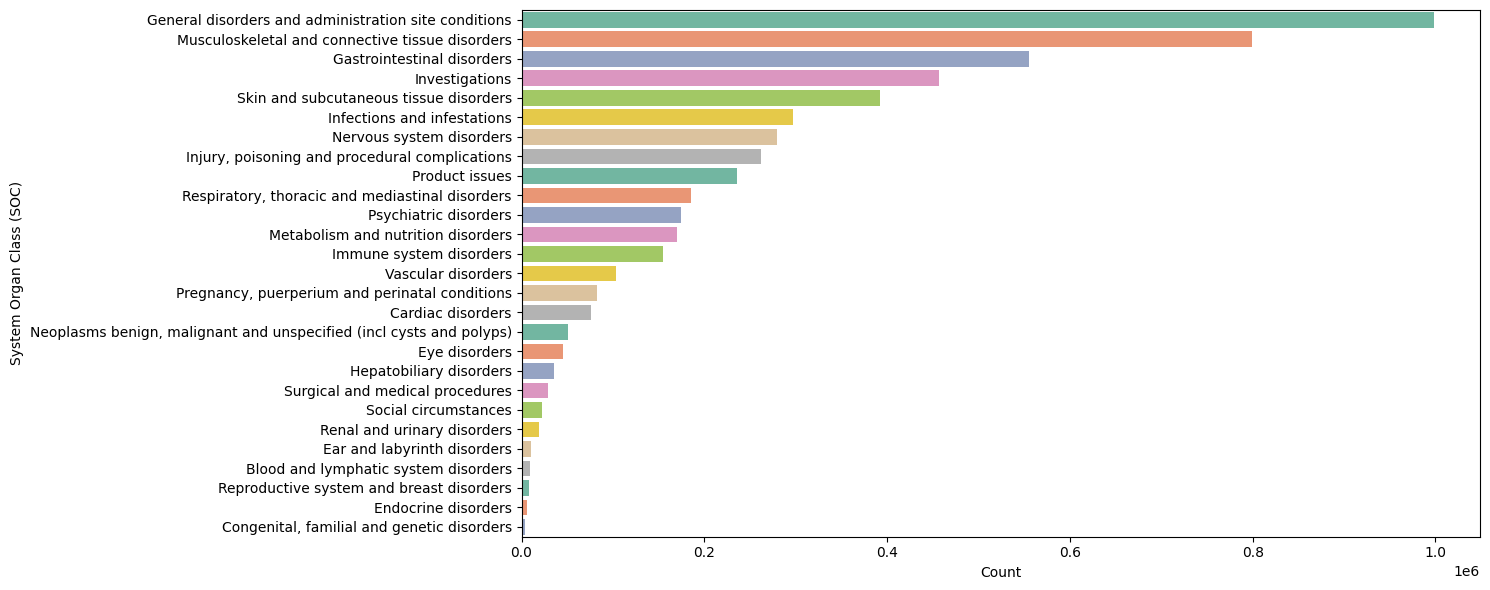

In [17]:
# Plot the distribution of SOCs
plt.figure(figsize=(15, 6))
sns.countplot(data=df, y='SOC', order=df['SOC'].value_counts().index, palette='Set2')
plt.xlabel('Count')
plt.ylabel('System Organ Class (SOC)')
plt.tight_layout()
plt.show()

In [18]:
# Save the final data
data.to_csv('data/faers_adalimumab_2020-2024_ungrouped_cleaned.csv', index=False)